# Top-k upper bounds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from analysis import selection
from postgres import explain
from transform import db, mosp

In [3]:
def read_workload(topk_length: int = np.nan, raw: str = "", *, linear: bool = True) -> pd.DataFrame:
    linear_suffix = "-linear" if linear else ""
    path = f"workloads/topk-setups/job-ues-results-topk-{topk_length}{linear_suffix}.csv" if not raw else raw
    df = pd.read_csv(path, converters={"query": mosp.MospQuery.parse, "ues_bounds": json.loads, "query_result": json.loads})
    df = selection.best_query_repetition(df, "label", performance_col="query_rt_total")
    df = selection.reorder(df)
    df.set_index("label", inplace=True)
    df["ues_final_bound"] = df["ues_final_bound"].astype("float")
    
    df.rename(columns={"query_rt_total": "rt", "ues_final_bound": "bound"}, inplace=True)
    if not raw:
        df["mode"] = "top-k"
        df["topk_length"] = topk_length
    else:
        df["mode"] = "ues"
        df["topk_length"] = 0
    df["linear"] = linear
    return df

In [4]:
print("Now reading UES workloads")
all_workloads = [read_workload(raw="workloads/job-ues-results-base-linear.csv", linear=True), read_workload(raw="workloads/job-ues-results-base.csv", linear=False)]
for topk_setting in [1, 5, 10, 20, 50, 100, 500]:
    print("Now reading workloads for topk =", topk_setting)
    all_workloads.append(read_workload(topk_setting, linear=True))
    all_workloads.append(read_workload(topk_setting, linear=False))
results = pd.concat(all_workloads)

Now reading UES workloads
Now reading workloads for topk = 1
Now reading workloads for topk = 5
Now reading workloads for topk = 10
Now reading workloads for topk = 20
Now reading workloads for topk = 50
Now reading workloads for topk = 100
Now reading workloads for topk = 500


In [5]:
results.groupby(["mode", "linear", "topk_length"]).rt.sum()

mode   linear  topk_length
top-k  False   1              384.841273
               5              392.619533
               10             393.579322
               20             395.623529
               50             394.737593
               100            385.806501
               500            382.638674
       True    1              404.534410
               5              418.798606
               10             417.877278
               20             418.343495
               50             417.462146
               100            421.909690
               500            419.633139
ues    False   0              376.990205
       True    0              393.746356
Name: rt, dtype: float64

In [6]:
results.groupby(["mode", "linear", "topk_length"]).bound.describe()

count          mean           std       min  \
mode  linear topk_length                                                
top-k False  1            113.0  1.959680e+17  1.972792e+18  150180.0   
             5            113.0  9.930727e+15  9.532100e+16    1160.0   
             10           113.0  1.797747e+15  1.682882e+16     900.0   
             20           113.0  4.214975e+14  3.773979e+15     790.0   
             50           113.0  5.606727e+13  5.834173e+14     764.0   
             100          113.0  8.512903e+12  8.935658e+13  150180.0   
             500          113.0  2.013742e+10  1.718704e+11   14049.0   
      True   1            113.0  1.959680e+17  1.972792e+18  150180.0   
             5            113.0  9.930727e+15  9.532100e+16    1160.0   
             10           113.0  1.797747e+15  1.682882e+16     900.0   
             20           113.0  4.214975e+14  3.773979e+15     790.0   
             50           113.0  5.606727e+13  5.834173e+14     764.0   
             100          113.0  8.512903e+12  8.935658e+13  150180.0   
             500          113.0  2.013742e+10  1.718704e+11   14049.0   
ues   False  0            113.0  1.959680e+17  1.972792e+18  150180.0   
      True   0            113.0  1.959680e+17  1.972792e+18  150180.0   

                                  25%           50%           75%  \
mode  linear topk_length                                            
top-k False  1            424168664.0  9.667429e+09  8.711122e+11   
             5             17106080.0  1.081999e+09  2.410247e+10   
             10            11305040.0  6.734479e+08  1.404086e+10   
             20             7303800.0  3.141781e+08  7.627424e+09   
             50             3613943.0  1.294136e+08  2.708854e+09   
             100           19157135.0  2.006026e+08  5.917777e+09   
             500            4630255.0  5.095397e+07  3.054260e+08   
      True   1            424168664.0  9.667429e+09  8.711122e+11   
             5             17106080.0  1.081999e+09  2.410247e+10   
             10            11305040.0  6.734479e+08  1.404086e+10   
             20             7303800.0  3.141781e+08  7.627424e+09   
             50             3613943.0  1.294136e+08  2.708854e+09   
             100           19157135.0  2.006026e+08  5.917777e+09   
             500            4630255.0  5.095397e+07  3.054260e+08   
ues   False  0            424168664.0  9.667429e+09  8.711122e+11   
      True   0            424168664.0  9.667429e+09  8.711122e+11   

                                   max  
mode  linear topk_length                
top-k False  1            2.096509e+19  
             5            1.011219e+18  
             10           1.782524e+17  
             20           3.980661e+16  
             50           6.202564e+15  
             100          9.499571e+14  
             500          1.809260e+12  
      True   1            2.096509e+19  
             5            1.011219e+18  
             10           1.782524e+17  
             20           3.980661e+16  
             50           6.202564e+15  
             100          9.499571e+14  
             500          1.809260e+12  
ues   False  0            2.096509e+19  
      True   0            2.096509e+19

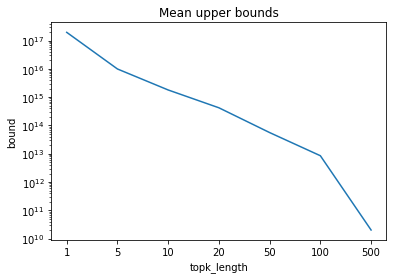

In [7]:
mean_topk_bounds = results[(results["mode"] == "top-k") & results["linear"]].groupby("topk_length").bound.mean().to_frame().reset_index()
mean_topk_bounds.topk_length = mean_topk_bounds.topk_length.astype(str)
g = sns.lineplot(data=mean_topk_bounds, x="topk_length", y="bound")
g.set(title="Mean upper bounds")
__ = g.set(yscale="log")

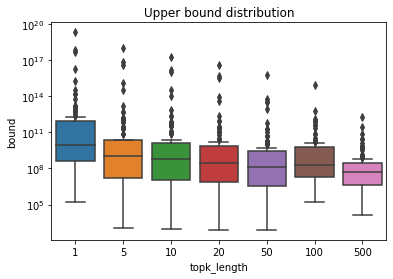

In [8]:
all_topk_bounds = results[(results["mode"] == "top-k") & results["linear"]].copy()
all_topk_bounds.topk_length = all_topk_bounds.topk_length.astype(str)
g = sns.boxplot(data=all_topk_bounds, x="topk_length", y="bound")
g.set(title="Upper bound distribution")
__ = g.set(yscale="log")

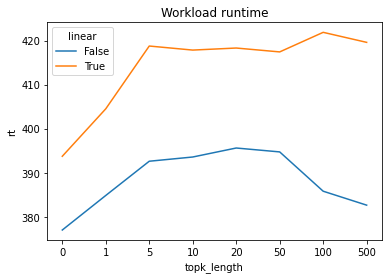

In [9]:
total_topk_runtime = results.groupby(["linear", "topk_length"]).rt.sum().to_frame().reset_index()
total_topk_runtime.topk_length = total_topk_runtime.topk_length.astype(str)
g = sns.lineplot(data=total_topk_runtime, x="topk_length", y="rt", hue="linear")
__ = g.set(title="Workload runtime")

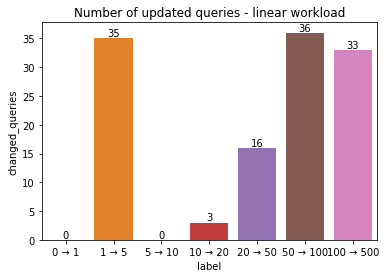

In [10]:
topk_settings = [0, 1, 5, 10, 20, 50, 100]
topk_setting_successors = [1, 5, 10, 20, 50, 100, 500]
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results[results["linear"] & (results["topk_length"] == topk)]
    topk_next_results = results[results["linear"] & (results["topk_length"] == topk_next)]
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries - linear workload")
__ = g.bar_label(g.containers[0])

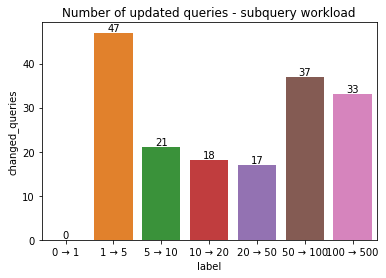

In [11]:
topk_settings = [0, 1, 5, 10, 20, 50, 100]
topk_setting_successors = [1, 5, 10, 20, 50, 100, 500]
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results[~results["linear"] & (results["topk_length"] == topk)]
    topk_next_results = results[~results["linear"] & (results["topk_length"] == topk_next)]
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries - subquery workload")
__ = g.bar_label(g.containers[0])